验证环境运行

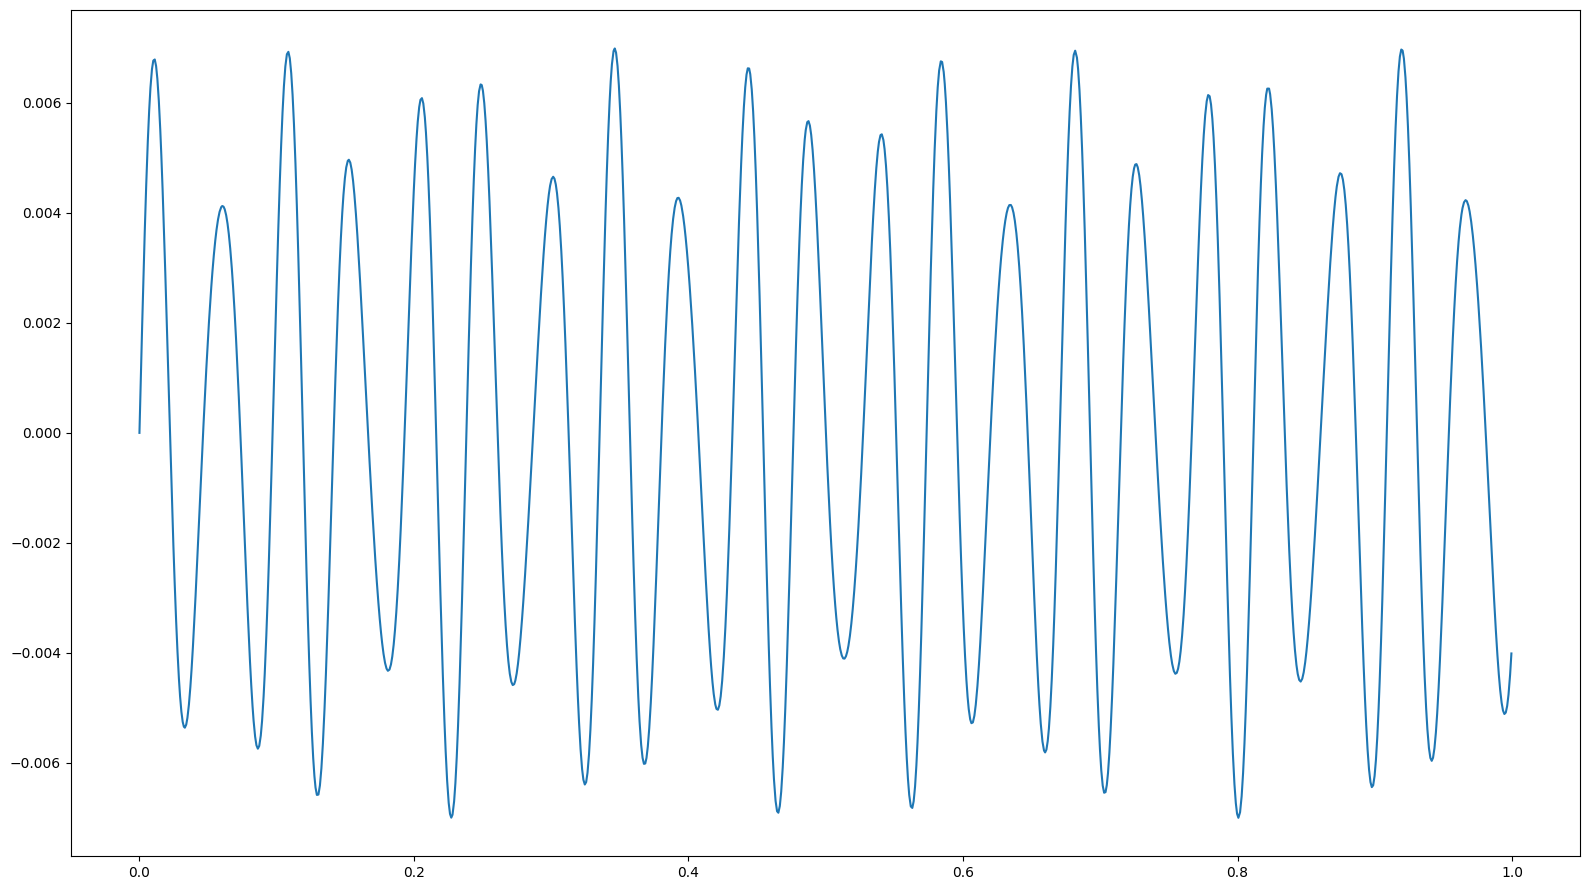

In [ ]:
import numpy as np

from fx import zero, tolerance_reward
from data import plot_data
def build_env():
    from env import ElectromagneticDamperEnv
    # 系统参数
    m = 1.0    # 电磁吸振器质量
    M = 15  # 待减振对象质量
    k_m = 30_000  # 电磁吸振器刚度
    k_M = 300_000  # 平台刚度
    k_f = 100 # * TD3_PARAMS['action_bound']  # 电—力常数 N/A
    k_E = 0.0  # 作动器反电动势系数
    L = 0.0045  # 线圈的电感
    R_m = 5.0  # 线圈的电阻
    c_m = 0.001 # 1.0  # 电磁吸振器阻尼
    c_M = 0.01 # 5.0  # 平台阻尼

    A = np.array(
        [
            [0.0, 1.0, 0.0, 0.0],
            [-k_m / m, -c_m / m, k_m / m, c_m / m],
            [0.0, 0.0, 0.0, 1.0],
            [k_m / M, c_m / M, -(k_m + k_M) / M, -(c_m + c_M) / M],
        ]
    )
    B = np.array([[0.0], [k_f / m], [0.0], [-k_f / M]])
    C = np.array(
        [
            [-k_m / m, -c_m / m, k_m / m, c_m / m],
            [k_m / M, c_m / M, -(k_m + k_M) / M, -(c_m + c_M) / M],
        ]
    )
    D = np.array([[+k_f / m], [-k_f / M]])
    E = np.array([[0.0, 0.0, 0.0, c_M / M], [0.0, 0.0, 0.0, k_M / M]]).T
    F = np.array([[0.0], [0.0], [0.0], [1 / M]])

    env = ElectromagneticDamperEnv(
        A=A,
        B=B,
        C=C,
        D=D,
        E=E,
        F=F,
        Ts=0.001,
        T=1.0,
        state0=np.array([0.0, 0.0, 0.0, 0.0, 1.0, 0.0]),
        obs_indices=[0, 1, 2, 3, 4, 5],
        x1_limit=10000,
        use_dt_noise=True,
        dt_noise_std=0.1,
        delay_enabled=True,
        delay_mean_steps=3,
        delay_std_steps=1,
        include_dt_in_obs=True,
        include_delay_in_obs=True,
        z_func=zero,
        r_func=tolerance_reward(1e-3),
        f_func=zero,
    )
    return env

test_env = build_env()
test_recorder = test_env.run_episode(record=True)
plot_data(x_values_list=test_recorder.as_numpy(keys='time_history'), y_values_list=test_recorder.as_numpy(keys='state_history')[:,3])

In [12]:
import numpy as np
import time
# 对比运行时间
def list_and_numpy():
    t0 = time.time()
    # python list
    l = list(range(100))
    for _ in range(10000):
        for i in range(len(l)):
            l[i] += 1
    t1 = time.time()
    # numpy array
    a = np.array(l)
    for _ in range(10000):
        a += 1
    print("Python list spend {:.3f}s".format(t1 - t0))
    print("Numpy array spend {:.3f}s".format(time.time() - t1))
list_and_numpy()

Python list spend 0.029s
Numpy array spend 0.005s


In [13]:
import numpy as np
import time
n = 10000000
# 场景1：预分配NumPy数组
start = time.time()
state_array = np.zeros((n, 3))  # 假设每个状态是3维向量
for i in range(n):
    state_array[i] = np.array([i*0.1, i*0.2, i*0.3])  # 模拟状态赋值
array_time = time.time() - start

# 场景3：动态扩展Python列表
start = time.time()
state_list = []
for i in range(n):
    state_list.append([i*0.1, i*0.2, i*0.3])  # 模拟状态赋值
list1_time = time.time() - start

# 场景3：动态扩展初始化的Python列表
start = time.time()
state_list = [None] * n # 预分配列表空间
for i in range(n):
    state_list[i] = [i*0.1, i*0.2, i*0.3]  # 模拟状态赋值
list2_time = time.time() - start

print(f"预分配NumPy数组耗时：{array_time:.6f}秒")
print(f"动态扩展列表耗时：{list1_time:.6f}秒")
print(f"动态扩展初始化的列表耗时：{list2_time:.6f}秒")
print(f"NumPy比动态扩展列表快 {list1_time/array_time:.2f} 倍")
print(f"NumPy比动态扩展初始化的列表快 {list2_time/array_time:.2f} 倍")

预分配NumPy数组耗时：4.983861秒
动态扩展列表耗时：4.257731秒
动态扩展初始化的列表耗时：3.786361秒
NumPy比动态扩展列表快 0.85 倍
NumPy比动态扩展初始化的列表快 0.76 倍
